In [44]:

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
import torch.nn.utils as utils
import torch.optim.lr_scheduler as lr_scheduler
from torch.distributions import Distribution
from torch.distributions.dirichlet import Dirichlet
from torch.utils.data import DataLoader
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import math
from typing import Tuple, List, Callable

from sklearn.preprocessing import StandardScaler
from torchvision import datasets, transforms
from torchvision import utils as vutils
from sklearn import metrics
from tqdm import tqdm
from sklearn.metrics import accuracy_score

from sklearn.model_selection import train_test_split
from scipy.stats import gaussian_kde
from IPython.display import clear_output

import wandb
import os 
os.environ['WANDB_NOTEBOOK_NAME'] = 'Coupling_mnist_plots.ipynb'
# set seed
torch.manual_seed(42)
np.random.seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

############ HYPERPARAMETERS ################
wandb.init(
    project='Normalising-Flow-DNN',
    config={
        "learning_rate": 0.0031,
        "weight_decay": 1e-6,
        "epochs": 5,
        "batch_size": 64,
        "validation_every_steps": 100, 
        'architecture': 'CNN',
        'dataset': 'MNIST'
    },
    #name='run_name',
    #tags=['experiment1', 'CNN'],
    #notes='Trying out a new architecture',
    #dir='/path/to/log/files',
    ##entity='my_team',
    #group='experiment_group',
    #job_type='train'
)
#lr = 0.00005
training_lr = 3e-4 # start of training (end of warmup ) #Note: High LR create NaNs and Inf 
start_lr = 1e-9 # start of warmup
min_lr = 1e-7 # during cosine annealing
num_epochs = 220 # flere epochs maybe 12000
warmup_steps= 500
validation_every_steps = 50 # is actually every epoch in training loop!!
#validation_every_epochs = 1
weight_decay = 5e-7  # L2 regularization strength to prevent overfitting in Adam or AdamW 
batch_size = 64
early_stop_delta = 0.001
early_stop_patience = 15
split = lambda x: x.chunk(2, dim=-1)
reg = 1e-6 # entropy regularisation
annealing_interval = 40 # Every 10 epochs, anneal LR (warm restart)

num_classes = 10
latent_dim = 6 # Change to 4 or 6    # the encoder outputs 2D latent space
data_dim = 6 # the encoder outputs 2D latent space
in_dim= data_dim // 2 # since we split the data
out_dim= data_dim // 2
num_params = 2 # s and t
num_hidden = 3 # number of hidden layers
hidden_dim = 64 # neurons in hidden layers
num_flows = 6 # number of coupling flow layers

# architecture='conv'
# input_dims=[28, 28, 1]
# output_dim=10
# hidden_dims=[64, 64, 64]
# kernel_dim=5
# latent_dim=6
# no_density=False
# density_type='radial_flow'
# n_density=6
# k_lipschitz=None
# budget_function='id'


cuda


batch_train_accuracy,▁▁▁▂▂▃▄▄▄▅▆▆▆▅▇▇▇▇▇▇▇▇▇▇▇█▇▇▇▇▇▇▇▇██▇▇██
batch_train_losses,██████▇▆▆▅▄▃▃▃▂▂▂▁▂▂▂▂▂▂▁▁▁▂▂▃▂▂▁▂▁▁▁▂▁▁
epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁███████████████████
learning_rate,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇███████████████████
step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train_accuracy,▁▁▂▃▃▄▄▅▅█████████
train_loss,███▇▆▆▅▅▅▁▁▁▁▁▁▁▁▁
val_accuracy,▁▂▄▅▆▆▇▇▇▇███████
val_loss,██▇▅▄▃▂▂▂▂▂▁▁▁▁▁▁
batch_train_accuracy,0.9375
batch_train_losses,0.25668


In [45]:

############ CLASSES ################
# Define the Normalising Flow model template
class NormalisingFlow(nn.Module):

    def __init__(self, latent: Distribution, flows: List[nn.Module]):
        super(NormalisingFlow, self).__init__()
        self.latent = latent
        self.flows = nn.ModuleList(flows)

    def latent_log_prob(self, z: torch.Tensor) -> torch.Tensor:
        log_prob_z = self.latent.log_prob(z)
        return log_prob_z

    def latent_sample(self, num_samples: int = 1) -> torch.Tensor:
        return self.latent.sample((num_samples,))

    def sample(self, num_samples: int = 1) -> torch.Tensor:
        '''Sample a new observation x by sampling z from
        the latent distribution and pass through g.'''
        return self.g(self.latent_sample(num_samples))

    def f(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        '''Maps observation x to latent variable z.
        Additionally, computes the log determinant
        of the Jacobian for this transformation.
        Inverse of g.'''
        #z, sum_log_abs_det = x, torch.zeros(x.size(0)).to(device) # change to x device
        
        z, sum_log_abs_det = x, torch.zeros(x.size(0), device = x.device)
        for flow in self.flows: # for each transformation in the flow
            z, log_abs_det = flow.f(z)
            sum_log_abs_det += log_abs_det

        return z, sum_log_abs_det

    def g(self, z: torch.Tensor) -> torch.Tensor:
        '''Maps latent variable z to observation x.
        Inverse of f.'''
        with torch.no_grad():
            x = z
            for flow in reversed(self.flows):
                x = flow.g(x)

        return x

    def g_steps(self, z: torch.Tensor) -> List[torch.Tensor]:
        '''Maps latent variable z to observation x
        and stores intermediate results.'''
        xs = [z]
        for flow in reversed(self.flows):
            xs.append(flow.g(xs[-1]))

        return xs

    def log_prob(self, x: torch.Tensor) -> torch.Tensor:
        '''Computes log p(x) using the change of variable formula.'''
        z, log_abs_det = self.f(x)
        log_prob_x = self.latent_log_prob(z) + log_abs_det
        return log_prob_x

    def __len__(self) -> int:
        return len(self.flows)

class AffineCouplingLayer(nn.Module):

    def __init__(self, theta: nn.Module, split: Callable[[torch.Tensor], Tuple[torch.Tensor, torch.Tensor]]):
        super(AffineCouplingLayer, self).__init__()
        self.theta = theta
        self.split = split

    def f(self, x: torch.Tensor) -> torch.Tensor:
        '''f: x -> z. The inverse of g.'''
        # split the input x into two halves
        x2, x1 = self.split(x) # flip the split #insert other permutation for 3D+ data
        ### permutation at one point
        t, s = self.theta(x1)
        # Tau coupling function: e^s + t
        z1, z2 = x1, x2 * torch.exp(s) + t
        # z1 and z2 are: torch.Size([64, 1]) which means that batch size is 64 and the dimension is 1
        log_det = s.sum(-1) # sum over the last dimension
        return torch.cat((z1, z2), dim=-1), log_det

    def g(self, z: torch.Tensor) -> torch.Tensor:
        '''g: z -> x. The inverse of f.'''
        z1, z2 = self.split(z)
        t, s = self.theta(z1)
        x1, x2 = z1, (z2 - t) * torch.exp(-s)
        return torch.cat((x2, x1), dim=-1)

class Conditioner(nn.Module):
    'The conditioner is the Neural Network that helps fit the model to the data by learning theta_i = (s_i,t_i)'

    def __init__(self, in_dim: int, out_dim: int, num_hidden: int, hidden_dim: int, num_params: int):
        super(Conditioner, self).__init__()
        self.input = nn.Sequential(
            nn.Linear(in_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),  
            nn.LeakyReLU(inplace=True)  
        )
        self.hidden = nn.ModuleList([
            nn.Sequential(
                nn.Linear(hidden_dim, hidden_dim),
                nn.BatchNorm1d(hidden_dim),  
                nn.Dropout(0.3),
                nn.LeakyReLU(inplace=True)  
            )
            for _ in range(num_hidden)
        ])

        self.num_params = num_params
        self.out_dim = out_dim
        self.output = nn.Linear(hidden_dim, out_dim * num_params)
        # initialisere output lag conditioner alle vægte og bias til 0
        nn.init.zeros_(self.output.weight)
        nn.init.zeros_(self.output.bias) 

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.input(x)
        for h in self.hidden:
            x = h(x)

        batch_params = self.output(x).reshape(x.size(0), self.out_dim, -1)
        #batch_params[:,:,1] *= 0.001
        #batch_params[:,:,0] *= 0.001 
        params = batch_params.chunk(self.num_params, dim=-1)
        return [p.squeeze(-1) for p in params]

class CNN(nn.Module):

    def __init__(self, latent_dim):
        super().__init__()
        self.latent_dim = latent_dim
        
        self.conv_block = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True),

            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2) 
        )

        self.linear_block = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64, latent_dim),
            nn.BatchNorm1d(latent_dim)
        )

    def forward(self, x):
        x = self.conv_block(x)
        #print("Shape after conv_block:", x.shape) #64batchsize x 64channels x 1height x 1width
        #x = x.view(x.size(0), -1) # flatten
        x = self.linear_block(x)
        return x

class PosteriorNetwork(nn.Module):
    def __init__(self, latent_dim: int, flow_models: List[nn.Module], N: torch.tensor, num_classes: int, y: torch.Tensor, reg: float):
        super(PosteriorNetwork, self).__init__()
        self.cnn = CNN(latent_dim)
        self.flow_models = nn.ModuleList(flow_models)
        self.N = N
        self.y = y
        self.num_classes = num_classes 
        self.reg = reg
    
    def forward(self, x, N):
        batch_size = x.size(0)
        # N is number of inputs in each class total
        z = self.cnn(x) 
        if torch.isnan(z).any() or torch.isinf(z).any():
            print("NaN or Inf in tensor z")
            print(torch.where(torch.isnan(z)))
            print(z[torch.where(torch.isnan(z))])
            # Change NaN value to 0
            z[torch.where(torch.isnan(z))] = 0

            print(torch.where(torch.isinf(z)))
            print(z[torch.where(torch.isinf(z))])
            # Change Inf value to 0
            z[torch.where(torch.isinf(z))] = 0
    
        # for each class, since outputdim = num_classes
        alpha = torch.zeros((batch_size, self.num_classes)).to(z.device.type)
        log_q = torch.zeros((batch_size, self.num_classes)).to(z.device.type)
        beta_i = torch.zeros((batch_size, self.num_classes)).to(z.device.type)

        # for each class, compute 
        for c in range(self.num_classes):
            log_prob = self.flow_models[c].log_prob(z) #P(z|c,phi)
            log_q[:,c] = log_prob
            beta_prior = 1 
            #formula (4) from paper
            beta_i[:,c] = N[c] * torch.exp(log_prob) #or log_q[:,c]
            alpha[:,c] = beta_prior + beta_i[:,c] #or just beta_i[c]?

        # grad_loss
        #loss = self.loss_postnet(alpha, y, batch_size)

        ##alpha = F.normalize(alpha, p=1, dim=1) # to get p^bar_c which is the average of alphas
        #preds = self.predict(alphas) #categorical prediction using argmax on p_bar_c
        return alpha

    def loss_postnet(self, alpha, y, batch_size): #UCE loss 
        #alpha is the p vector with alphas for each class
        #y_hot is the ground-truth class labels
        alpha_0 = torch.sum(alpha, dim=1, keepdim=True) #batch x 1
        digamma_alpha_0 = torch.digamma(alpha_0) # batch x 1, hver obs får sin egent logprobs
        digamma_alpha_c = torch.digamma(alpha[range(batch_size),y]) # batch x 1

        uce_loss_elements = digamma_alpha_c - digamma_alpha_0 #elementwise
        #uncertain_loss = torch.sum((digamma_alpha_c - digamma_alpha_sum) * alpha, dim=1)
        
        # entropy regularisation in Dirichlet distribution
        entropy_reg = Dirichlet(alpha).entropy() #tensor of batch shape

        postnet_loss = torch.mean(-uce_loss_elements) + self.reg * torch.sum(entropy_reg) #negative since we want to minimize the loss
        #approximates the true posterior distribution for the categorical distribution p
        return postnet_loss
    
############ LOAD MNIST DATASET ################
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
batch_size = 64 # standard value
from torch.utils.data.dataset import Subset

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
#subset_percentage = 0.1
#num_samples = int(len(train_dataset) * subset_percentage)
#print("Number of samples:", num_samples)
num_train = int(len(train_dataset) * 0.5)
num_test = int(len(test_dataset) * 0.5)
print("n_train", num_train, "n_test", num_test)
train_subset = Subset(train_dataset, range(num_train))
test_subset = Subset(test_dataset, range(num_test)) 

train_loader = DataLoader(train_subset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_subset, batch_size=64, shuffle=False)

# Get ground-truth label counts N_c
# Dictionary with class names from indexes.
classes = {index: name for name, index in train_dataset.class_to_idx.items()}

# Initialise dictionary to store the counts for each class using class indexes
N = {index: 0 for index in range(len(classes))}
# Count the occurrences of each class
#for _, target in train_dataset:
for _, target in train_subset:
    N[target] += 1
N = torch.tensor([N[index] for index in range(len(classes))])
print("N:", N)

#y_train = torch.tensor([target for _, target in train_dataset])
y_train = torch.tensor([target for _, target in train_subset])

############# FUNCTION ##################
def image_show(img):
    img = img.detach().cpu()
    img = img / 2 + 0.5   #Unnormalise
    with sns.axes_style("white"):
        plt.figure(figsize=(8, 8))
        plt.imshow(img.permute((1, 2, 0)).numpy())
        plt.axis('off')
        plt.show()

def init_weights(model):
    if isinstance(model, nn.Linear):
        nn.init.xavier_normal_(model.weight)
        nn.init.zeros_(model.bias) 

def accuracy(y_train, preds):
    accuracy = accuracy_score(y_train.cpu().numpy(), preds.cpu().numpy())
    return accuracy

############# INSTANTIATE MODEL ##################


flow_models = []
for class_label in range(num_classes):
    conditioner = Conditioner(in_dim=in_dim, out_dim=out_dim, num_hidden=num_hidden, hidden_dim=hidden_dim, num_params=num_params)
    affine_coupling = AffineCouplingLayer(conditioner, split=split) # split the tensor into 2 parts
    flows = [affine_coupling for _ in range(num_flows)]
    latent_distribution = torch.distributions.MultivariateNormal(loc=torch.zeros(data_dim).to(device), scale_tril=torch.eye(data_dim).to(device)) #maybe move out of loop?

    flow_model = NormalisingFlow(latent_distribution, flows).to(device)
    #flow_model = NormalisingFlow(latent_distribution, flows).apply(init_weights).to(device)
    flow_models.append(flow_model)

postnet_model = PosteriorNetwork(latent_dim, flow_models, N, num_classes, y_train, reg).to(device) 
optimiser = optim.AdamW(postnet_model.parameters(), lr=training_lr, weight_decay=weight_decay)

class GradualWarmupScheduler(torch.optim.lr_scheduler._LRScheduler):
    def __init__(self, optimizer, warmup_steps, start_lr, end_lr, last_epoch=-1):
        self.warmup_steps = warmup_steps
        self.start_lr = start_lr
        self.end_lr = end_lr
        self.lr_increment = (end_lr - start_lr) / warmup_steps
        super().__init__(optimizer, last_epoch)

    def get_lr(self):
        if self.last_epoch < self.warmup_steps:
            lr = self.start_lr + self.last_epoch * self.lr_increment
            return [lr for _ in self.base_lrs]
        return self.base_lrs
warmup_scheduler = GradualWarmupScheduler(optimiser, warmup_steps=warmup_steps, start_lr=start_lr, end_lr=training_lr)

total_steps_per_epoch = len(train_loader)  # Total batches (steps) per epoch
warmup_epochs = math.ceil(warmup_steps / total_steps_per_epoch)  # Total warmup epochs
#T_max = num_epochs - warmup_epochs  # Total number of training epochs minus warmup epochs
print("total_steps_per_epoch", total_steps_per_epoch)
print("Warmup epochs:", warmup_epochs)
#print("Training epochs T_max: ", T_max)
# rounded up to make sure all warmup steps are used before AnnealingLR

#T_max = 10
training_scheduler = lr_scheduler.CosineAnnealingLR(optimiser, T_max=annealing_interval, eta_min=min_lr, last_epoch=-1)
#scheduler = torch.optim.lr_scheduler.StepLR(optimiser, step_size=5, gamma=0.1)
#torch_lr_scheduler = ExponentialLR(optimizer=default_optimizer, gamma=0.98)

n_train 30000 n_test 5000
N: tensor([2961, 3423, 2948, 3073, 2926, 2709, 2975, 3107, 2875, 3003])
total_steps_per_epoch 469
Warmup epochs: 2


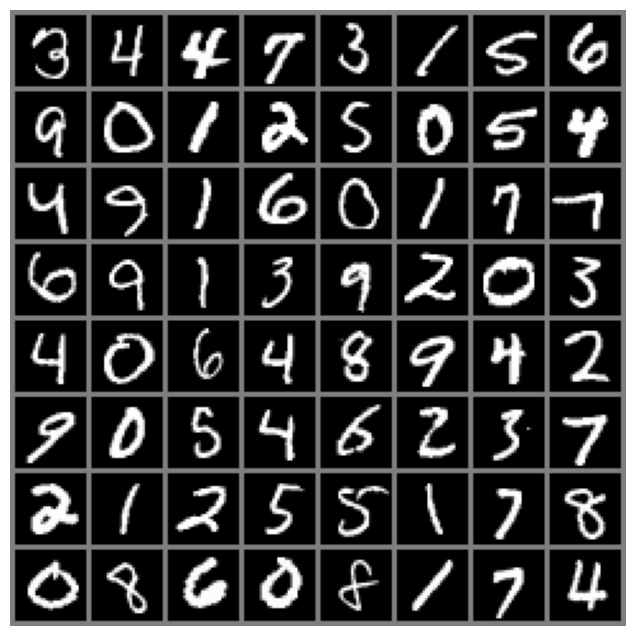

In [46]:
# Get random training images and show them.
images, labels = next(iter(train_loader))
image_show(vutils.make_grid(images))

In [47]:
############## TRAINING ######################
def train(model, optimiser, train_loader, test_loader, num_epochs, validation_every_steps, 
          early_stop_delta, early_stop_patience, warmup_scheduler, training_scheduler, warmup_steps):
    model.train()
    train_losses, train_accuracies, val_losses, val_accuracies = [], [], [], []
    all_train_losses = []
    best_val_loss = float("Inf")
    step = 0 # how many batches we have trained on (each batch is 64 samples) #9000 training samples / 64 batch size = 140 batches per epoch
    counter = 0 # for early stopping 
    early_stopping = False
    wandb.watch(model, log="all")

    for epoch in range(num_epochs): #epoch is one forward pass through the entire training set
        train_losses_batches, train_accuracies_batches = [], []
        #batches_counter = 0

        for batch_index, (X_train, y_train) in enumerate(train_loader):
            X_train, y_train = X_train.to(device), y_train.to(device)
            # batches_counter += 1

            # Forward pass
            alpha = model(X_train, N)
            loss = model.loss_postnet(alpha, y_train, X_train.size(0)) #batch size
            # Perform one training step
            optimiser.zero_grad()
            loss.backward()
            utils.clip_grad_norm_(flow_model.parameters(), max_norm=5.0)
            
            optimiser.step()
            if step < warmup_steps:
                warmup_scheduler.step()
            
            step += 1
            #train_losses.append(loss.item())

            # Compute training accuracy and loss for this batch
            with torch.no_grad():
                preds = torch.max(alpha, dim=-1)[1]
                train_accuracy_batch = accuracy(y_train, preds)
                train_accuracies_batches.append(train_accuracy_batch)
                train_losses_batches.append(loss.item())
                all_train_losses.append(loss.item())
                current_lr = optimiser.param_groups[0]['lr']
                wandb.log({"batch_train_losses": loss.item(), "batch_train_accuracy": 
                           train_accuracy_batch, "step": step, "learning_rate": current_lr, "epoch": epoch})
                #wandb.log({"batch_train_losses": loss.item(), "batch_train_accuracy": 
                           #train_accuracy_batch, "step": step})
                
                #train_accuracies.append(batch_accuracy)

            # if epoch >= warmup_epochs:
            #     if (epoch - warmup_epochs) % annealing_interval == 0:
            #         training_scheduler.step()

            if step % validation_every_steps == 0:
                train_loss = np.mean(train_losses_batches)
                train_losses.append(train_loss)
                train_accuracy = np.mean(train_accuracies_batches)
                train_accuracies.append(train_accuracy)
                wandb.log({"train_loss": train_loss, "train_accuracy": train_accuracy, "step": step})

                val_losses_batches = []
                #val_accuracies_batches = []
                val_correct = []
                model.eval()
                with torch.no_grad():   
                    for batch_index, (X_test, y_test) in enumerate(test_loader):
                        X_test, y_test = X_test.to(device), y_test.to(device)
                        # Evaluation Forward pass
                        alpha = model(X_test, N) # gives a vector with alphas for each class
                        loss = model.loss_postnet(alpha, y_test, X_test.size(0)) #gives a loss
                        
                        # Evaluation accuracy and loss for this batch
                        preds = torch.max(alpha, dim=-1)[1]
                        
                        correct_batch = (preds == y_test).sum().item()
                        val_correct.append(correct_batch)

                        #Maybe: Multiply by len(x) because the final batch of DataLoader may be smaller (drop_last=False).
                        #val_accuracies_batches.append(accuracy(y_test, preds) * len(X_test))

                        # append the loss for this batch
                        val_losses_batches.append(loss.item())

                val_accuracy = sum(val_correct) / len(test_subset) # or use len(test_dataset)
                #Multiply by len(test_dataset) because the final batch of DataLoader may be smaller (drop_last=False).
                val_accuracies.append(val_accuracy)
                val_loss = np.mean(val_losses_batches) 
                val_losses.append(val_loss)
                wandb.log({"val_loss": val_loss, "val_accuracy": val_accuracy, "step": step})
                model.train()

                if val_losses[-1] < -1.:
                    print("Unstable training")
                    break
                if np.isnan(val_losses[-1]):
                    print('Detected NaN Loss')
                    break
                # If val_loss is the best so far, save the model state_dict and reset the early stopping counter
                if val_losses[-1] < best_val_loss:
                    best_val_loss = val_losses[-1]
                    counter = 0
                    best_model = model.state_dict()
                    torch.save({'epoch': epoch, 'model_state_dict': best_model, 'loss': best_val_loss}, 'best_model_moons_entropy.pth')
                    print('Model saved')

                # Early stopping - if val_loss is not improving (plus a delta e-4 as buffer) then start counter
                # after patience of a certain number of validations, then stop training
                elif val_losses[-1] > (best_val_loss + early_stop_delta):
                    counter += 1
                    if counter >= early_stop_patience:
                        #print("Early stopping")
                        early_stopping = True
                        break
                
                print(f"Step: {step}, Epoch: {epoch+1}\tTrain Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}, Train Accuracy: {train_accuracies[-1]:.4f}, Val Accuracy: {val_accuracies[-1]:.4f}")
                #### Lave plots med meshgrid f-funktion af normalising flow undervejs for at se ændringen
        
        # Update training scheduler (annealing LR)
        if epoch >= warmup_epochs:
                #if (epoch - warmup_epochs) % annealing_interval == 0:
                training_scheduler.step()
        #current_lr = optimiser.param_groups[0]['lr']
        #print(f"Epoch {epoch}: Current Epoch LR = {current_lr}")

        if early_stopping: # if true
            print("Early stopping triggered. Exiting training.")
            break  # Break out of the outer loop
    print("Finished training.")
    return train_losses, val_losses, train_accuracies, val_accuracies, all_train_losses #,model

train_losses, val_losses, train_accuracies, val_accuracies, all_train_losses = train(postnet_model, optimiser, train_loader, test_loader, 
                                                num_epochs, validation_every_steps, early_stop_delta, early_stop_patience, warmup_scheduler, 
                                                training_scheduler, warmup_steps)

Model saved
Step: 50, Epoch: 1	Train Loss: 2.5721, Val Loss: 2.5370, Train Accuracy: 0.1347, Val Accuracy: 0.1474
Model saved
Step: 100, Epoch: 1	Train Loss: 2.5478, Val Loss: 2.4945, Train Accuracy: 0.1817, Val Accuracy: 0.2874
Model saved
Step: 150, Epoch: 1	Train Loss: 2.4605, Val Loss: 2.1752, Train Accuracy: 0.2450, Val Accuracy: 0.4522
Model saved
Step: 200, Epoch: 1	Train Loss: 2.2900, Val Loss: 1.6232, Train Accuracy: 0.3110, Val Accuracy: 0.5768
Model saved
Step: 250, Epoch: 1	Train Loss: 2.0914, Val Loss: 1.2100, Train Accuracy: 0.3741, Val Accuracy: 0.6670
Model saved
Step: 300, Epoch: 1	Train Loss: 1.9060, Val Loss: 0.9690, Train Accuracy: 0.4313, Val Accuracy: 0.7248
Model saved
Step: 350, Epoch: 1	Train Loss: 1.7496, Val Loss: 0.8188, Train Accuracy: 0.4785, Val Accuracy: 0.7650
Model saved
Step: 400, Epoch: 1	Train Loss: 1.6161, Val Loss: 0.6952, Train Accuracy: 0.5191, Val Accuracy: 0.7972
Model saved
Step: 450, Epoch: 1	Train Loss: 1.5111, Val Loss: 0.6793, Train Accur

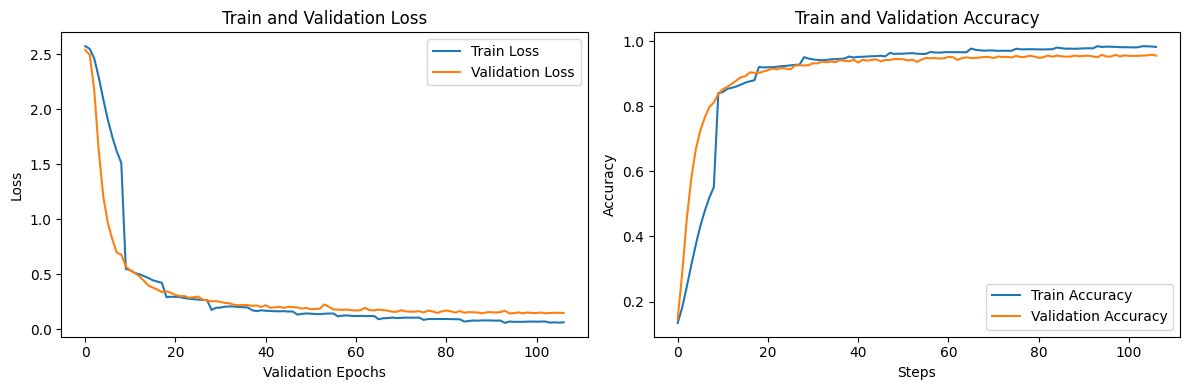

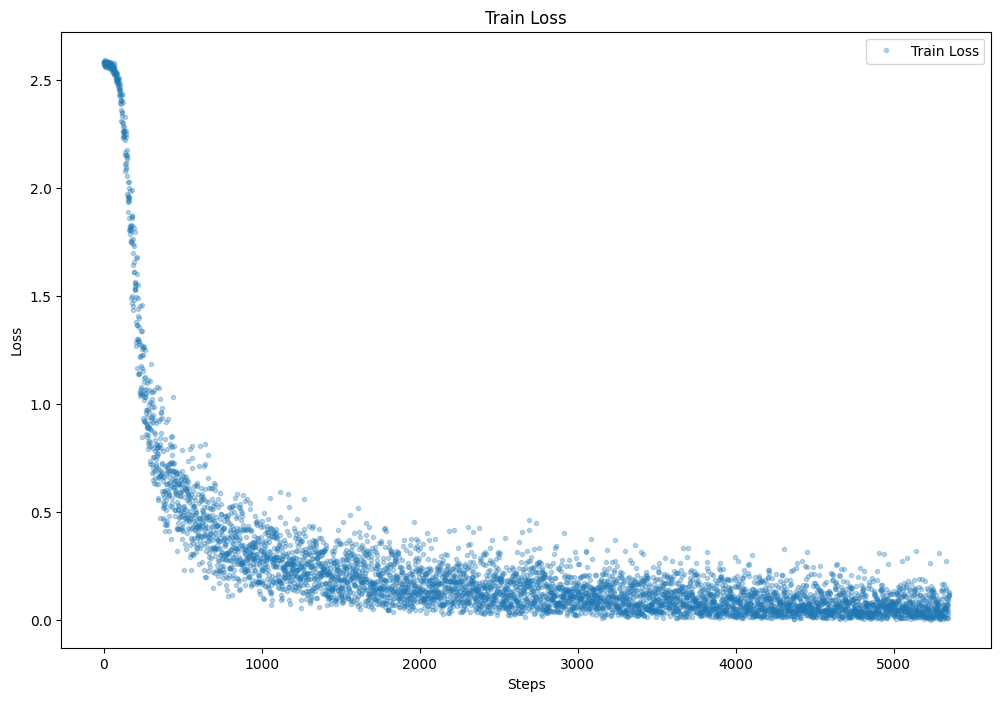

In [49]:
# Plot loss of training and validation
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].plot(train_losses, label='Train Loss')
axes[0].plot(val_losses, label='Validation Loss')
axes[0].set_xlabel('Validation Epochs')
axes[0].set_ylabel('Loss')
axes[0].set_title('Train and Validation Loss')
axes[0].legend()

# Plot accuracies of training and validation
axes[1].plot(train_accuracies, label='Train Accuracy')
axes[1].plot(val_accuracies, label='Validation Accuracy')
axes[1].set_xlabel('Steps')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Train and Validation Accuracy')
axes[1].legend()
plt.tight_layout()
plt.savefig('plots_mnist/training_loss_acc.png', bbox_inches='tight')

# plot all_train_losses
plt.figure(figsize=(12,8))
plt.plot(all_train_losses,  '.',label='Train Loss', alpha=0.3)
#plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.title('Train Loss')
plt.legend()
plt.savefig('plots_mnist/training_all_losses_acc.png', bbox_inches='tight')

In [48]:


# Plot the meshgrid of the learned latent space
# Create a meshgrid in the latent space
coords = 3.8
denseness = 700
nx, ny = (denseness, denseness)
x = np.linspace(-coords, coords, nx)
y = np.linspace(-coords, coords, ny)
xv, yv = np.meshgrid(x, y)
mesh = np.stack((xv.flatten(), yv.flatten()), axis=1)
mesh_tensor = torch.FloatTensor(mesh).to(device)

# Run the train data through only the CNN using the best_model.pt
latent_train_data = best_model.cnn(X_train_tensor.to(device)).cpu().detach().numpy()
# Run a meshgrid of datapoints through encoder (and then through flow) to get logprobs
latent_mesh = best_model.cnn(mesh_tensor.to(device))



NameError: name 'best_model' is not defined

In [ ]:
# Plot the meshgrid of the learned latent space
# Create a meshgrid in the latent space
coords = 3.8
denseness = 700
nx, ny = (denseness, denseness)
x = np.linspace(-coords, coords, nx)
y = np.linspace(-coords, coords, ny)
xv, yv = np.meshgrid(x, y)
mesh = np.stack((xv.flatten(), yv.flatten()), axis=1)
mesh_tensor = torch.FloatTensor(mesh).to(device)

# Run the train data through only the CNN using the best_model.pt
latent_train_data = best_model.cnn(X_train_tensor.to(device)).cpu().detach().numpy()
# Run a meshgrid of datapoints through encoder (and then through flow) to get logprobs
latent_mesh = best_model.cnn(mesh_tensor.to(device))

num_samples = 1000
samples, posterior_samples, generated_samples = [], [], []
# Compute log-probabilities for each class
logprobs, logprobs_mesh = [], []
for i in range(num_classes):
    log_prob = flow_models[i].log_prob(mesh_tensor).clamp(min=-10, max=10)
    logprobs.append(log_prob.cpu().reshape((nx, ny)).detach().numpy())
    # run latent_mesh through flow to get logprobs
    log_prob_mesh = flow_models[i].log_prob(latent_mesh).clamp(min=-10, max=10)
    logprobs_mesh.append(log_prob_mesh.cpu().reshape((nx, ny)).detach().numpy())

    # Get samples in the latent space
    samples.append(best_model.flow_models[i].sample(num_samples).to(device)) #self.g(self.latent_sample(num_samples))
    # Sample from the posterior distribution using the NormalisingFlow object
    post = best_model.flow_models[i].latent_sample(num_samples).to(device)
    posterior_samples.append(post)    


# Show what the normalising flow has learned
plt.figure(figsize=(6, 4))
plt.imshow(np.exp(logprobs_mesh[0]), extent=[-2, 2, -2, 2], origin='lower', cmap='viridis', alpha=1)
plt.imshow(np.exp(logprobs_mesh[1]), extent=[-2, 2, -2, 2], origin='lower', cmap='viridis', alpha=0.5)
plt.colorbar(label='Probability Density')
plt.xlabel('Input Dimension 1')
plt.ylabel('Input Dimension 2')
plt.title('Before Encoder Combined Probability Density for Both Classes')
plt.show()

#Grid er datapunkter – køre gennem encoder – og så gennem flow og regne logprobs og plot der
# BEFORE encoder plot the logprobs_mesh as heatmaps for each class
colors = ['red', 'green']
plt.figure(figsize=(12,4))
for class_label in range(num_classes):
    plt.subplot(1, num_classes, class_label + 1)
    plt.imshow(np.exp(logprobs_mesh[class_label]), extent=[-coords, coords, -coords, coords], origin='lower', cmap='viridis')
    plt.colorbar()
    plt.scatter(X_train[y_train == class_label][:, 0], X_train[y_train == class_label][:, 1],
                c=colors[class_label], alpha=0.07, label=f'True Class {class_label}')
    plt.xlabel('Input Dimension 1')
    plt.ylabel('Input Dimension 2')
    plt.legend(loc='upper left')
    plt.title(f'Before encoder Class {class_label} Probability Density map with Train Data ') 
plt.tight_layout()
plt.show()

# AFTER encoder Plot the log probabilities as heatmaps for each class
colors = ['red', 'red']
plt.figure(figsize=(12,4))
for class_label in range(num_classes):
    plt.subplot(1, num_classes, class_label + 1)
    plt.imshow(np.exp(logprobs[class_label]), extent=[-coords, coords, -coords, coords], origin='lower', cmap='viridis')
    plt.colorbar()
    plt.scatter(latent_train_data[y_train == class_label][:, 0], latent_train_data[y_train == class_label][:, 1],
                c=colors[class_label], alpha=0.07, label=f'True Class {class_label}')
    plt.xlabel('Latent Dimension 1')
    plt.ylabel('Latent Dimension 2')
    plt.legend(loc='upper left')
    plt.title(f'After encoder Class {class_label} Probability Density with Train Data')
plt.tight_layout()
plt.show()

plt.figure(figsize=(12,4))
for class_label in range(num_classes):
    plt.subplot(1, num_classes, class_label + 1)
    plt.imshow(np.exp(logprobs[class_label]), extent=[-coords, coords, -coords, coords], origin='lower', cmap='viridis')
    plt.colorbar()
    plt.scatter(samples[class_label][:, 0].numpy(), samples[class_label][:, 1].numpy(), 
                c=colors[class_label],s=10, alpha=0.07, label=f'Generated Class {class_label}')
    plt.xlabel('Latent Dimension 1')
    plt.ylabel('Latent Dimension 2')
    plt.legend(loc='upper left')
    plt.title(f'Class {class_label} Probability Density with Generated \nSamples from the normalising flow')
plt.tight_layout()
plt.show()

# Plot the log probabilities for both classes in the same plot
plt.figure(figsize=(8, 6))
plt.imshow(np.exp(logprobs[0]), extent=[-2, 2, -2, 2], origin='lower', cmap='viridis', alpha=1)
plt.imshow(np.exp(logprobs[1]), extent=[-2, 2, -2, 2], origin='lower', cmap='viridis', alpha=0.5)
plt.colorbar(label='Probability Density')
plt.xlabel('Latent Dimension 1')
plt.ylabel('Latent Dimension 2')
plt.title('Combined Probability Density for Both Classes')
plt.show()


NameError: name 'train_losses' is not defined

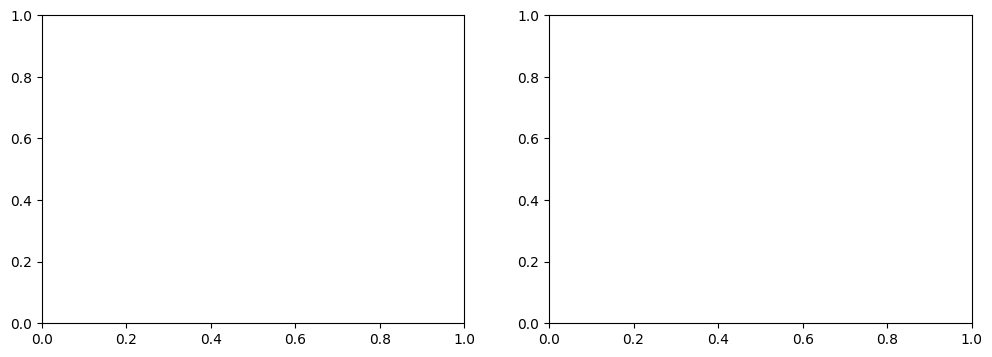

In [ ]:

# Plot loss of training and validation
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].plot(train_losses, label='Train Loss')
axes[0].plot(val_losses, label='Validation Loss')
axes[0].set_xlabel('Validation Epochs')
axes[0].set_ylabel('Loss')
axes[0].set_title('Train and Validation Loss')
axes[0].legend()

# Plot accuracies of training and validation
axes[1].plot(train_accuracies, label='Train Accuracy')
axes[1].plot(val_accuracies, label='Validation Accuracy')
axes[1].set_xlabel('Steps')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Train and Validation Accuracy')
axes[1].legend()
plt.tight_layout()
plt.savefig('plots_mnist/training_loss_acc.png', bbox_inches='tight')

# plot all_train_losses
plt.figure(figsize=(12,8))
plt.plot(all_train_losses,  '.',label='Train Loss', alpha=0.3)
#plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.title('Train Loss')
plt.legend()
plt.savefig('plots_mnist/training_all_losses_acc.png', bbox_inches='tight')

In [ ]:
# Load the best model from pth file type
device = torch.device("cpu")
flow_models = []
for class_label in range(num_classes):
    conditioner = Conditioner(in_dim=in_dim, out_dim=out_dim, num_hidden=num_hidden, hidden_dim=hidden_dim, num_params=num_params)
    affine_coupling = AffineCouplingLayer(conditioner, split=lambda x: x.chunk(2, dim=-1)) # split the tensor into 2 parts
    flows = [affine_coupling for _ in range(num_flows)]
    latent_distribution = torch.distributions.MultivariateNormal(loc=torch.zeros(data_dim).to(device), scale_tril=torch.eye(data_dim).to(device))

    flow_model = NormalisingFlow(latent_distribution, flows). to(device)
    #flow_model = NormalisingFlow(latent_distribution, flows).apply(init_weights).to(device)
    flow_models.append(flow_model)
best_model = PosteriorNetwork(latent_dim, flow_models, N, num_classes, y_train, reg).to(device)
best_model.load_state_dict(torch.load('best_model_mnist.pth', map_location=device)['model_state_dict'])


# Test best model on test data
N = N.to(device) #move num classes to device just in case
alpha_values = []
# print(next(best_model.parameters()).is_cuda)
best_model.eval()
with torch.no_grad():
    for batch_index, (X_test_batch, y_test_batch) in enumerate(test_loader):
        X_test_batch, y_test_batch = X_test_batch.to(device), y_test_batch.to(device)
        # Forward pass to compute alpha values for this batch
        alpha_preds = best_model(X_test_batch, N) # batch x num_classes    
        # Append the alpha values to the list
        #print(alpha_preds.shape)
        alpha_values.append(alpha_preds)

# Combine alpha values from all batches list into a single tensor
alpha_values = torch.cat(alpha_values, dim=0)
print("Alpha values shape: ", alpha_values.shape)

# Normalize alpha values
alphas_norm = F.normalize(alpha_values, p=1, dim=1) #reduce to dim 1, sum to 1

Alpha values shape:  torch.Size([1000, 10])


In [ ]:
# Plot the 
best_model.eval()  # Set the model to evaluation mode

# Function to get 2D features from the model
def get_2d_features(model, loader):
    features, labels = [], []
    with torch.no_grad():
        for data, label in loader:
            data = data.to(device)
            feature = model.cnn(data)  # get the 2D features from the model
            features.append(feature.cpu().detach().numpy())
            labels.append(label.numpy())

    return np.concatenate(features), np.concatenate(labels)

# Get 2D features and labels
features_2d, labels = get_2d_features(best_model, train_loader


In [ ]:
def plot_2d_features(features, labels):
    plt.figure(figsize=(10, 8))
    for i in range(10):  # Assuming 10 classes (0-9) for MNIST
        idxs = labels == i
        plt.scatter(features[idxs, 0], features[idxs, 1], label=str(i))

    plt.legend()
    plt.title("2D Features from CNN Encoder")
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.show()

plot_2d_features(features_2d, labels)

In [ ]:
latent_train_data = best_model.cnn(train_dataset.to(device)).cpu().detach().numpy()

# plot the latent space datapoints and see how they change
fig, axes = plt.subplots(1, 1, figsize=(12, 5))
axes.scatter(latent_train_data[y_train == 0][:, 0], latent_train_data[y_train == 0][:, 1], c=rainbow_colors_c0, label='True Class 0', marker='o')
axes.scatter(latent_train_data[y_train == 1][:, 0], latent_train_data[y_train == 1][:, 1], c=rainbow_colors_c1, label='True Class 1', marker='o')
axes.set_xlabel('Feature 1')
axes.set_ylabel('Feature 2')
axes.legend(loc='upper left')
axes.set_title('Latent Space')
plt.tight_layout()
plt.show()

AttributeError: 'MNIST' object has no attribute 'to'

In [ ]:
import torch
from torch.distributions import Dirichlet
import torch.nn.functional as F
# Example alpha parameters
reg = 0.01
alpha = torch.tensor([[10., 2., 3.], [4., 7., 6.]])
print("Alpha: \t\t", alpha)
alpha = F.normalize(alpha, p=1)
print("Alpha norm: \t", alpha)
y = torch.tensor([[0],[1]])
batch_size = 2
def loss_postnet(alpha, y, batch_size): #UCE loss 
    #alpha is the p vector with alphas for each class
    #y_hot is the ground-truth class labels
    alpha_0 = torch.sum(alpha, dim=1, keepdim=True) #batch x 1
    print("alpha_0:", alpha_0)
    digamma_alpha_0 = torch.digamma(alpha_0) # batch x 1, hver obs får sin egent logprobs
    digamma_alpha_c = torch.digamma(alpha[range(batch_size),y]) # batch x 1
    
    print("digamma_alpha_0:", digamma_alpha_0)
    print("digamma_alpha_c:", digamma_alpha_c)
    uce_loss_elements = digamma_alpha_c - digamma_alpha_0 #elementwise
    print("UCE elements:", uce_loss_elements)
    #uncertain_loss = torch.sum((digamma_alpha_c - digamma_alpha_sum) * alpha, dim=1)

    uce_loss = torch.mean(-uce_loss_elements) #negative since we want to minimize the loss
    print("UCE loss:", uce_loss)

    # entropy regularisation in Dirichlet distribution
    entropy_reg = Dirichlet(alpha).entropy() #tensor of batch shape
    print("Entropy_reg: ", entropy_reg)
    postnet_loss = torch.mean(uce_loss) - reg * torch.sum(entropy_reg) #negative since we want to minimize the loss

    #approximates the true posterior distribution for the categorical distribution p
    return postnet_loss
uce_loss = loss_postnet(alpha, y, batch_size)
print("Postnet loss with entropy reg:", uce_loss)
#print("UCE: ", uce_loss)

def loss_postnet_basic(alpha, y, batch_size):
        alpha_0 = torch.sum(alpha, dim=1, keepdim=True) #batch x 1
        digamma_alpha_c = torch.digamma(alpha[range(batch_size),y]) # batch x 1

        digamma_alpha_0 = torch.digamma(alpha_0) # batch x 1, hver obs får sin egent logprobs
        uce_loss_elements = digamma_alpha_c - digamma_alpha_0 #elementwise
        #uncertain_loss = torch.sum((digamma_alpha_c - digamma_alpha_sum) * alpha, dim=1)
        
        # entropy in Dirichlet distribution
        uce_loss = -torch.mean(uce_loss_elements) 
        print("Basic UCE loss:", uce_loss)
basic = loss_postnet_basic(alpha, y, batch_size)